In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [247]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [248]:
#read data
production_ice_cream=pd.read_csv('ice_cream.csv',parse_dates=[0],index_col=0,squeeze=True,date_parser=parser)

In [249]:
production_ice_cream.rename('production',inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [250]:
#infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [251]:
#just get data from 2010 onwoards
start_date =pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

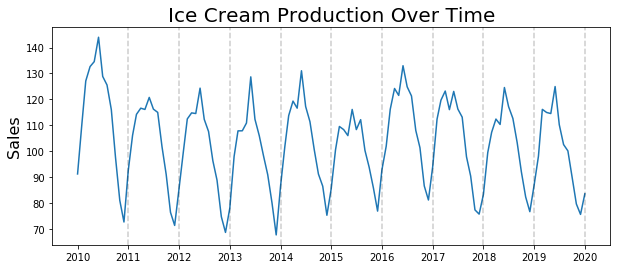

In [252]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production Over Time', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-'+'-01-01'), color='k', linestyle='--', alpha=0.2)

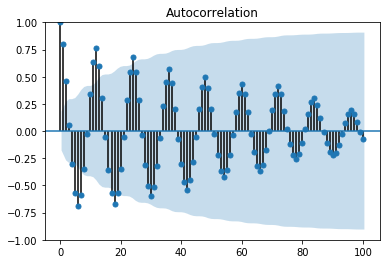

In [253]:
Acf_plot = plot_acf(production_ice_cream,lags=100)

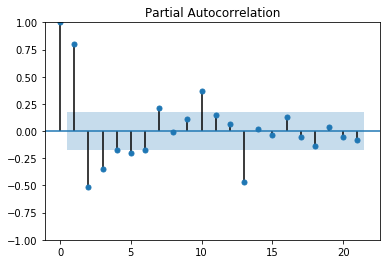

In [254]:
pacf_plot=plot_pacf(production_ice_cream,method='ywm')

In [255]:
#get Training and testing sets
train_end=datetime(2018,12,1)
test_end=datetime(2019,12,1)
train_data=production_ice_cream[:train_end]
test_data=production_ice_cream[train_end + timedelta(days=1):test_end]

In [256]:
test_data

DATE
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
2019-06-01    124.9605
2019-07-01    110.2632
2019-08-01    102.6085
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
Freq: MS, Name: production, dtype: float64

In [257]:
train_end

datetime.datetime(2018, 12, 1, 0, 0)

In [258]:
train_end + timedelta(days=31)

datetime.datetime(2019, 1, 1, 0, 0)

In [259]:
production_ice_cream[train_end:test_end]

DATE
2018-12-01     76.7608
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
2019-06-01    124.9605
2019-07-01    110.2632
2019-08-01    102.6085
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
Freq: MS, Name: production, dtype: float64

In [260]:
production_ice_cream[train_end+timedelta(days=1):test_end]

DATE
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
2019-06-01    124.9605
2019-07-01    110.2632
2019-08-01    102.6085
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
Freq: MS, Name: production, dtype: float64

In [261]:
#Create and fit AR Model
model=ARIMA(train_data,order=(3,0,0))

In [262]:
#fit the model
start =time()
model_fit = model.fit()
end=time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.25681042671203613


In [263]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Tue, 14 Jun 2022   AIC                            758.170
Time:                        16:39:18   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [264]:
#start_prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date=test_data.index[-1]

In [265]:
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)

In [266]:
predictions

2019-01-01     81.236249
2019-02-01     90.140510
2019-03-01    101.523172
2019-04-01    111.164049
2019-05-01    117.060582
2019-06-01    118.125846
2019-07-01    115.033483
2019-08-01    109.355515
2019-09-01    103.142077
2019-10-01     98.184812
2019-11-01     95.616387
2019-12-01     95.699737
Freq: MS, Name: predicted_mean, dtype: float64

In [268]:
Residuals=test_data-predictions

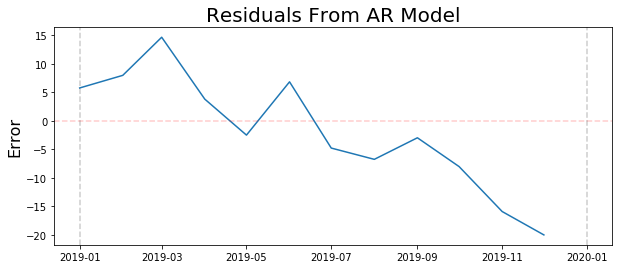

In [269]:
plt.figure(figsize=(10,4))
plt.plot(Residuals)
plt.title('Residuals From AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-'+'-01-01'), color='k', linestyle='--', alpha=0.2)

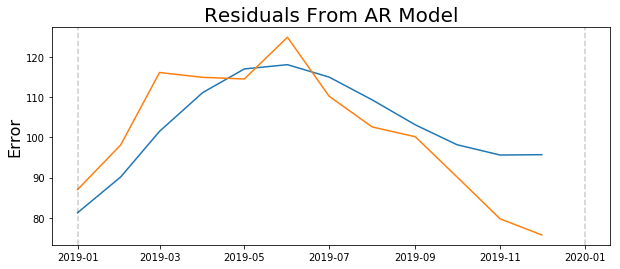

In [270]:
plt.figure(figsize=(10,4))
plt.plot(predictions)
plt.plot(test_data)
plt.title('Residuals From AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-'+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [271]:
print('Mean Absolute Percent Error:',round(np.mean(abs(Residuals/test_data)),4))

Mean Absolute Percent Error: 0.0895


In [272]:
print('Root Mean square:',np.sqrt(np.mean(Residuals**2)))

Root Mean square: 9.884158745176794


In [273]:
model_fit.params

const     103.574257
ar.L1       1.046920
ar.L2      -0.052315
ar.L3      -0.404438
sigma2     58.402582
dtype: float64

In [274]:
model_fit.pvalues

const     0.000000e+00
ar.L1     1.117199e-24
ar.L2     7.653288e-01
ar.L3     1.000563e-03
sigma2    7.111816e-10
dtype: float64

In [275]:
df=pd.DataFrame({'pval':model_fit.pvalues,'coeff':model_fit.params})
df

,pval,coeff
const,0.000000e+00,103.574257
ar.L1,1.117199e-24,1.046920
ar.L2,7.653288e-01,-0.052315
ar.L3,1.000563e-03,-0.404438
sigma2,7.111816e-10,58.402582


In [276]:
df.query('pval < 0.05')
np.where(df['pval']<0.05,1,0)

array([1, 1, 0, 1, 1])

In [277]:
df['x']=np.where(df['pval']<0.05,1,0)

In [278]:
df

,pval,coeff,x
const,0.000000e+00,103.574257,1
ar.L1,1.117199e-24,1.046920,1
ar.L2,7.653288e-01,-0.052315,0
ar.L3,1.000563e-03,-0.404438,1
sigma2,7.111816e-10,58.402582,1
